# McStasRead demo

In [1]:
from read_example import make_instrument, plot

In [2]:
instr = make_instrument()
instr.show_parameters()

 wavelength        = 2.0  // 
 delta_wavelength  = 0.1  // 


In [3]:
instr.set_parameters(wavelength=1.8, delta_wavelength=1.3)
instr.settings(ncount=1E6)

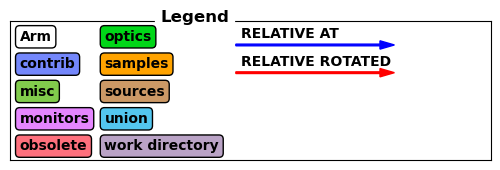

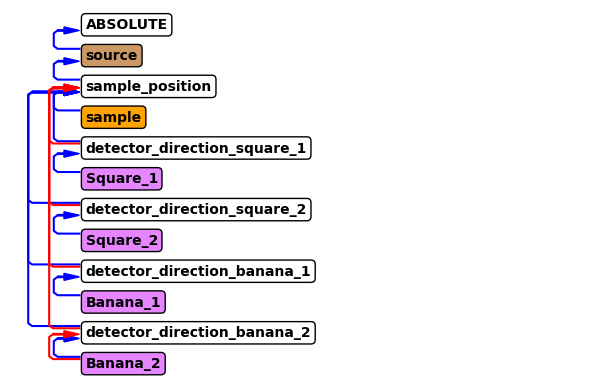

In [4]:
instr.show_diagram()

### Run simulation

In [5]:
data = instr.backengine()


INFO: Using directory: "/Users/madsbertelsen/Projects/McStasToX/github/McStasToX/test_18"
INFO: Regenerating c-file: test.c
CFLAGS=
      
 The parameter format of sample is initialized 
 using a static {,,,} vector.
  -> Such static vectors support literal numbers ONLY.
  -> Any vector use of variables or defines must happen via a 
     DECLARE/INITIALIZE pointer.


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
INFO: Recompiling: ./test.out
INFO: ===
Opening input file '/opt/miniconda3/envs/odin_env_1/share/mcstas/resources/data/Cu.laz' (Table_Read_Offset)
Table from file 'Cu.laz' (block 1) is 19 x 18 (x=1:6), constant step. interpolation: linear
  '# TITLE *-Cu-[FM3-M] Otte, H.M.[1961];# CELL 3.615050 3.615050 3.615050 90. ...'
PowderN: sample: Reading 

In [6]:
data

[
 McStasDataEvent: Banana_1 with 139171 events. Variables: p th y n id t,
 
 McStasDataEvent: Square_1 with 4171 events. Variables: p x y n id t L,
 
 McStasDataEvent: Banana_2 with 86321 events. Variables: p th y n id t,
 
 McStasDataEvent: Square_2 with 7870 events. Variables: p x y n id t]

### Histogram data to display

In [7]:
hist_data = [mon.make_2d(mon.variables[1], "y") for mon in data]

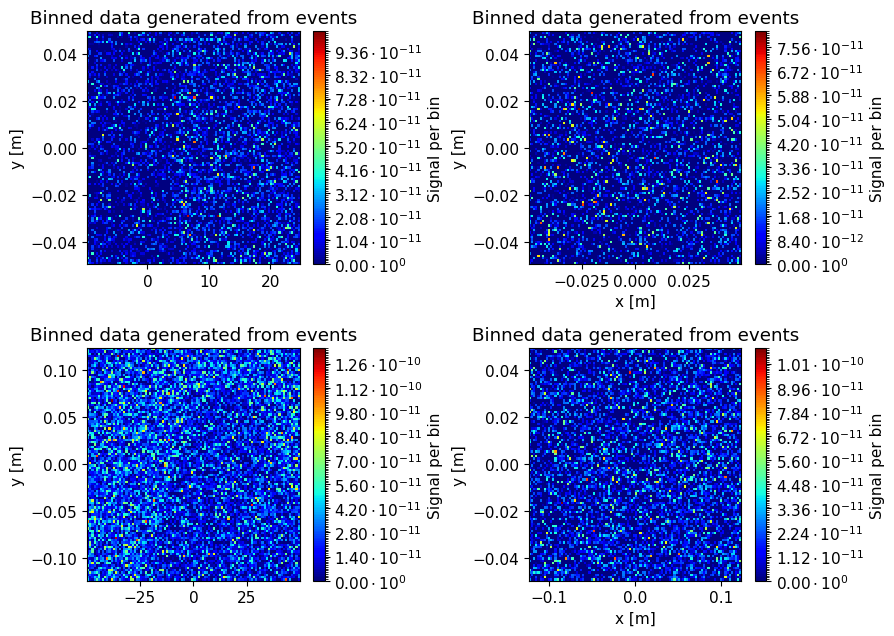

In [8]:
import mcstasscript as ms
ms.make_sub_plot(hist_data)

In [9]:
file_path = data[0].original_data_location
print(file_path)

/Users/madsbertelsen/Projects/McStasToX/github/McStasToX/test_18


In [10]:
%matplotlib widget

### Show list of components found in NeXus file

In [11]:
import mcstastox

with mcstastox.Read(file_path) as loaded_data:
    loaded_data.show_components()

All components in file:
  source
  sample_position
  sample
  detector_direction_square_1
  Square_1
  detector_direction_square_2
  Square_2
  detector_direction_banana_1
  Banana_1
  detector_direction_banana_2
  Banana_2


#### Show list of these with available data

In [12]:
with mcstastox.Read(file_path) as loaded_data:
    loaded_data.show_components_with_data()

All components with data in file:
  Square_1
  Square_2
  Banana_1
  Banana_2


In [13]:
with mcstastox.Read(file_path) as loaded_data:
    variables = loaded_data.get_component_variables("Square_1")
    print(variables)

p x y n id t L 


#### Show list of these with geometry information

In [14]:
with mcstastox.Read(file_path) as loaded_data:
    loaded_data.show_components_with_geometry()

All components with geometry information in file:
  Square_1
  Square_2
  Banana_1
  Banana_2


#### Show monitors with pixel ID's

In [15]:
with mcstastox.Read(file_path) as loaded_data:
    loaded_data.show_components_with_ids()

All components with pixel id information in file:
  Square_1
  Square_2
  Banana_1
  Banana_2


In [16]:
with mcstastox.Read(file_path) as loaded_data:
    print(loaded_data.get_components_with_ids())

['Square_1', 'Square_2', 'Banana_1', 'Banana_2']


### Export to Scipp object
Using the *export_scipp* method we get a scipp DataGroup that contains:
- events : the data
- positions : positions of the pixel ids
- bank_ids : pixel id range for each detector bank
- bank_names : names of the loaded detector banks

This structure requires a little more knowledge to work with than the simple export, but saves space and provides more flexibility.

In [17]:
with mcstastox.Read(file_path) as loaded_data:
    scipp_object = loaded_data.export_scipp(source_name="source",
                                            sample_name="sample_position")

In [18]:
scipp_object

DataGroup(sizes={'pixel_id': 1115, 'panel_id': 4, 'pixel': 2}, keys=[
    events: DataArray({'pixel_id': 1115}),
    positions: Variable({'pixel_id': 1115}),
    bank_ids: Variable({'panel_id': 4, 'pixel': 2}),
    bank_names: Variable({'panel_id': 4}),
])

In [19]:
scipp_object["bank_names"]

<scipp.Variable> (panel_id: 4)     string        <no unit>  ["Square_1", "Square_2", "Banana_1", "Banana_2"]

In [20]:
scipp_object["bank_ids"]

<scipp.Variable> (panel_id: 4, pixel: 2)      int64  [dimensionless]  [0, 224, ..., 915, 1114]

In [21]:
scipp_object["positions"]

<scipp.Variable> (pixel_id: 1115)    vector3              [m]  [(-0.189227, -0.0466667, 1.70189), (-0.194334, -0.0466667, 1.70617), ..., (0.925161, 1.01753, 1.39059), (0.836993, 1.10865, 1.42294)]

In [22]:
scipp_object["events"]

<scipp.DataArray>
Dimensions: Sizes[pixel_id:1115, ]
Coordinates:
* pixel_id                    int64  [dimensionless]  (pixel_id)  [0, 1, ..., 1113, 1114]
* position                  vector3              [m]  (pixel_id)  [(-0.189227, -0.0466667, 1.70189), (-0.194334, -0.0466667, 1.70617), ..., (0.925161, 1.01753, 1.39059), (0.836993, 1.10865, 1.42294)]
* sample_position           vector3              [m]  ()  (0, 0, 2)
* source_position           vector3              [m]  ()  (0, 0, 0)
Data:
                          DataArrayView        <no unit>  (pixel_id)  binned data: dim='events', content=DataArray(
          dims=(events: 36453),
          data=float64[counts],
          coords={'t':float64[s]})

## Plot pixels with intensities
With this setup we can plot the total intensity in each pixel rather than all events individually.

In [23]:
import plopp as pp

pp.scatter3d(scipp_object["events"].hist(), pos='position', size=0.015, cbar=True, norm="log")

Figure(children=(HBar(children=(HTML(value=''),)), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(…

### Perform coordinate transforms
Coordinate transformations can be done almost as before, they just need to be summed over all *pixel_id* when plotted.

In [24]:
from scippneutron.conversion.graph.beamline import beamline
from scippneutron.conversion.graph.tof import elastic

event_object = scipp_object["events"]

# McStas provides absolute time, not time of flight
event_object.bins.coords["tof"] = event_object.bins.coords["t"]

graph = {**beamline(scatter=True), **elastic("tof")}

In [25]:
event_object = event_object.transform_coords("dspacing", graph=graph)

Note extra .sum("pixel_id") in plot.

In [26]:
event_object.hist(dspacing=150).sum("pixel_id").plot(norm="log")

InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', la…